# Setting multiple Dirichlet condition

In the previous section, we used a single function to $u_d$ to setting Dirichlet conditions on two parts of the boundary. However, it is often more practical to use multiple functins, one for each subdomain of the boundary. We consider a similar example to [the previous example](./neumann_dirichlet) and redefine it consist of two Dirichlet boundary conditions

```{math}

-\nabla^2 u &=f && \text{in } \Omega,
u&=u_L && \text{on } \Lambda_D^L\\
u&=u_R && \text{on } \Lambda_D^R\\
-\frac{\partial u}{\partial n} &= g && \text{on } \Lambda_N.
```
Here, $\Lambda_D^L$ is the left boundary $x=0$,  while $\Lambda_D^R$ is the right boundary $x=1$. 
We note that $u_L(y)=1+2y^2$, $u_R(y)=2+2y^2$ and $g(y)=-4y$ using the same analytical example as in the previous section.

We start by defining the mesh, function space and variational formulation as in the previous exercise

In [1]:
import dolfinx
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py import PETSc

def u_exact(x):
    return 1 + x[0]**2 + 2*x[1]**2

mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 10, 10)
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v))*ufl.dx
x = ufl.SpatialCoordinate(mesh)
g = - 4 * x[1]
f = dolfinx.Constant(mesh, -6)
L = f * v * ufl.dx - g * v * ufl.ds

We next mark the two boundaries separately, starting with the left boundary

In [2]:
dofs_L = dolfinx.fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
u_L = dolfinx.Function(V)
u_L.interpolate(lambda x: 1 + 2*x[1]**2)
u_L.vector.ghostUpdate(PETSc.InsertMode.INSERT_VALUES, PETSc.ScatterMode.FORWARD)
bc_L = dolfinx.DirichletBC(u_L, dofs_L)

Note that we have used `lambda`-functions to compactly define the functions returning the subdomain evaluation and function evaluation. We can use a similar procedure for the right boundary condition, and gather both boundary conditions in a vector `bcs`.

In [3]:
dofs_R = dolfinx.fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1))
u_R = dolfinx.Function(V)
u_R.interpolate(lambda x: 2 + 2*x[1]**2)
u_R.vector.ghostUpdate(PETSc.InsertMode.INSERT_VALUES, PETSc.ScatterMode.FORWARD)
bc_R = dolfinx.DirichletBC(u_R, dofs_R)
bcs = [bc_R, bc_L]

We are now ready to again solve the problem, and check the $L^2$ and max error at the mesh vertices.

Error_L2 = 5.27e-03
Error_max = 5.33e-15


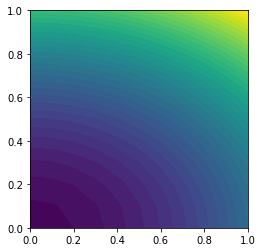

In [4]:
A = dolfinx.fem.assemble_matrix(a, bcs=bcs)
A.assemble()
b = dolfinx.fem.assemble_vector(L)
dolfinx.fem.apply_lifting(b, [a], [bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
dolfinx.fem.set_bc(b, bcs)

uh = dolfinx.Function(V)
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
solver.setOperators(A)
solver.solve(b, uh.vector)
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES,mode=PETSc.ScatterMode.FORWARD)

import dolfinx.plotting
dolfinx.plotting.plot(uh)

V2 = dolfinx.FunctionSpace(mesh, ("CG", 2))
uex = dolfinx.Function(V2)
uex.interpolate(u_exact)
uex.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
error_L2 = dolfinx.fem.assemble_scalar((uh - uex)**2 * ufl.dx)
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = uex.compute_point_values()
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print("Error_L2 = {0:.2e}".format(error_L2))
print("Error_max = {0:.2e}".format(error_max))